In [1]:
text = "You say goodbye and I say hello."

In [2]:
#전처리
#특수문자 제거, 문장끝 표현, 단어 소문자화 등등

text = text.lower()
text = text.replace('.',' .')

In [5]:
words = text.split(' ')

In [70]:
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [7]:
#id를 부여하는 과정

word_to_id = {}
id_to_word={}

for word in words:
  if word not in word_to_id:
    new_id = len(word_to_id)
    word_to_id[word] = new_id
    id_to_word[new_id]=word


In [8]:
word_to_id

{'.': 6, 'and': 3, 'goodbye': 2, 'hello': 5, 'i': 4, 'say': 1, 'you': 0}

In [9]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [40]:
import numpy as np

In [41]:
# 전처리 함수화

def preprocess(text):
  text = text.lower()
  text = text.replace(".", " .")
  words = text.split(' ')
  word_to_id = {}
  id_to_word={}

  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id]=word
 
  #1
  corpus = np.array([word_to_id[w] for w in words])
  
  #2
  # corpus = []
  # for w in words:
  #   corpus.append(word_to_id[w])
  # corpus = np.array(corpus)

  return corpus,word_to_id,id_to_word

In [42]:
text = "You say goodbye and I say hello."
corpus,word_to_id,id_to_word = preprocess(text)

In [43]:
def create_co_matrix(corpus,vocab_size,window_size=1):
  corpus_size = len(corpus)

  # 모든값이 0인 행렬을 선언
  co_matrix = np.zeros((vocab_size,vocab_size),dtype = np.int32)
  
  #corpus를 반복문으로 탐색
  for idx,word_id in enumerate(corpus):
    for i in range(1,window_size+1):
      left_idx = idx - i
      right_idx = idx + i 

      # 양끝 데이터처리 (데이터가 없는 경우)
      if left_idx >= 0 :
        left_word_id = corpus[left_idx]
        co_matrix[word_id,left_word_id] += 1
      if right_idx < corpus_size:
        right_word_id = corpus[right_idx]
        co_matrix[word_id,right_word_id] += 1
  return co_matrix
  

In [44]:
# 동시발생 행렬
C = create_co_matrix(corpus,vocab_size=len(word_to_id))

In [45]:
C[word_to_id["you"]]

array([0, 1, 0, 0, 0, 0, 0], dtype=int32)

In [46]:
# 코사인유사도.

def cos_similarity(x,y,eps=1e-8):
  nx = x/(np.sqrt(sum(x**2))+eps) # x / ||X||
  ny = y/(np.sqrt(sum(y**2))+eps) # y / ||Y||

  return np.dot(nx,ny) # x*y // ||X|| ||Y||


In [47]:
c0 = C[word_to_id["you"]]
c1 = C[word_to_id["i"]]
cos_similarity(c0,c1)

0.7071067691154799

In [48]:
# PPMI

def ppmi(C,eps=1e-8):
  # pmi 계산을 위해 빈 행렬정의
  M = np.zeros_like(C,dtype=np.float64)
  N = np.sum(C) # 동시발생행렬의 합
  S = np.sum(C,axis=0)
  total = C.shape[0] * C.shape[1]
  cnt=0

  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      pmi = np.log2(C[i,j] * N / (S[j]*S[i]) + eps)
      M[i,j] = max(0,pmi)
    return M

In [49]:
W=ppmi(C)
np.set_printoptions(precision=3)
print(W)

[[0.    1.807 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]


In [50]:
U,S,V = np.linalg.svd(W)

In [51]:
print(U[0])

[1. 0. 0. 0. 0. 0. 0.]


In [52]:
import matplotlib.pyplot as plt

ValueError: ignored

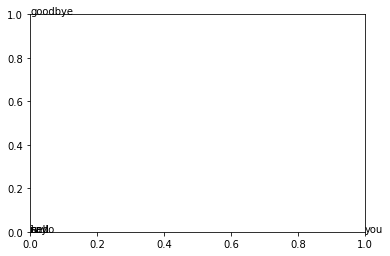

In [58]:
for word,word_id in word_to_id.items():
  plt.annotate(word,(U[word_id,0],U[word_id,1]))
plt.scatter(U[:0],U[:1],alpha=0.5)

In [59]:
# coding: utf-8
import sys
import os
sys.path.append('..')
try:
    import urllib.request
except ImportError:
    raise ImportError('Use Python3!')
import pickle
import numpy as np


url_base = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/'
key_file = {
    'train':'ptb.train.txt',
    'test':'ptb.test.txt',
    'valid':'ptb.valid.txt'
}
save_file = {
    'train':'ptb.train.npy',
    'test':'ptb.test.npy',
    'valid':'ptb.valid.npy'
}
vocab_file = 'ptb.vocab.pkl'

dataset_dir = ''


def _download(file_name):
    file_path = dataset_dir + '/' + file_name
    if os.path.exists(file_path):
        return

    print('Downloading ' + file_name + ' ... ')

    try:
        urllib.request.urlretrieve(url_base + file_name, file_path)
    except urllib.error.URLError:
        import ssl
        ssl._create_default_https_context = ssl._create_unverified_context
        urllib.request.urlretrieve(url_base + file_name, file_path)

    print('Done')


def load_vocab():
    vocab_path = dataset_dir + '/' + vocab_file

    if os.path.exists(vocab_path):
        with open(vocab_path, 'rb') as f:
            word_to_id, id_to_word = pickle.load(f)
        return word_to_id, id_to_word

    word_to_id = {}
    id_to_word = {}
    data_type = 'train'
    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name

    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()

    for i, word in enumerate(words):
        if word not in word_to_id:
            tmp_id = len(word_to_id)
            word_to_id[word] = tmp_id
            id_to_word[tmp_id] = word

    with open(vocab_path, 'wb') as f:
        pickle.dump((word_to_id, id_to_word), f)

    return word_to_id, id_to_word


def load_data(data_type='train'):
    '''
        :param data_type: 데이터 유형: 'train' or 'test' or 'valid (val)'
        :return:
    '''
    if data_type == 'val': data_type = 'valid'
    save_path = dataset_dir + '/' + save_file[data_type]

    word_to_id, id_to_word = load_vocab()

    if os.path.exists(save_path):
        corpus = np.load(save_path)
        return corpus, word_to_id, id_to_word

    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name
    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()
    corpus = np.array([word_to_id[w] for w in words])

    np.save(save_path, corpus)
    return corpus, word_to_id, id_to_word

In [60]:
corpus,word_to_id,id_to_word = load_data('train')

Done


In [62]:
print("말뭉치크기 : ", len(corpus))

말뭉치크기 929589


In [63]:
corpus[:30]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [65]:
for id in corpus[:30]:
  print(id_to_word[id], end=' ')

aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos> pierre <unk> N years old 

In [67]:
C = create_co_matrix(corpus,vocab_size=len(word_to_id))

In [69]:
W = ppmi(C)
U,S,V = np.linalg.svd(W)